<a href="https://colab.research.google.com/github/carolina-garay/grupo_32/blob/Entregable_parte1_parte2_Garay/Entregable_Parte_2_Garay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2022**

---
# Trabajo práctico entregable - Parte 2

*Grupo 32*

Integrantes: 
- Garay, Carolina del Valle
- Ormaechea, Sebastián Gabriel
- Ramos, Pablo Nicolás
- Reviglio, Valentín
- Siner, Magalí
             
Introducción:

En el presente documento se estudian los procedimientos para determinar si hay diferencias en el salario mensual neto promedio separado por categorías "Hombre" y "Otros". Para ello hacemos uso de la construcción de intervalos de confianza y pruebas de hipótesis.


## Importación de librerías necesarias

In [161]:
# 
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn as sns
import scipy
import scipy.stats as stats
from scipy.stats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power

sns.set_context('talk')

## Lectura del dataset


In [162]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df_orig = pd.read_csv(url)
df_orig.shape

(6095, 48)

In [163]:
df_orig[['profile_gender', 'salary_monthly_NETO']].groupby('profile_gender').describe()

salary_monthly_NETO                                     \
                             count          mean            std   min   
profile_gender                                                          
Hombre                      4944.0  98836.063558  102159.664237   1.0   
Mujer                        908.0  73501.414465   56256.880181   2.0   
Otros                         31.0  95441.354839   88635.674358  40.0   

                                                       
                    25%      50%       75%        max  
profile_gender                                         
Hombre          53285.0  80000.0  110000.0  2080000.0  
Mujer           43818.0  65000.0   92000.0   800000.0  
Otros           39500.0  74000.0  117500.0   380000.0

Para resolver los ejercicos utilizamos la base de datos que filtramos en el Entregable 1

In [164]:
s_neto= 'salary_monthly_NETO'
# Filtrado de la base de datos original (df_orig) y generación de la nueva base de datos (df_new)
df_new=  df_orig[(df_orig[s_neto] > 54207) & (df_orig[s_neto] < 542070)]

# Revisar si hay filas duplicadas
df_new.duplicated().any() # Si, hay filas duplicadas, ya que aparece True.

# Lo siguiente permite observar ambas filas de cada fila duplicada.
df_new[df_new.duplicated(keep=False)]

# Eliminación de filas duplicadas
df_final = df_new.drop_duplicates().reset_index()


In [165]:

is_man = df_final.profile_gender == 'Hombre' # Esta asignación permite seleccionar 
                                            # aquellas filas que correspondan a genero "Hombre"

groupA = df_final[is_man].salary_monthly_NETO     #Se seleccionan las filas que correspondan a género hombre junto a la columna de salary_monthly_NETO
groupB = df_final[~is_man].salary_monthly_NETO;  #Se seleccionan las filas que correspondan a género que "no" sea hombre junto a la columna de salary_monthly_NETO
print("grupoA:",groupA)
print("grupoB:",groupB)

grupoA: 0        63000.0
2       102000.0
3       106000.0
4        62400.0
5        75000.0
          ...   
4154     56450.0
4155    130000.0
4156     97000.0
4157     71000.0
4158     65000.0
Name: salary_monthly_NETO, Length: 3582, dtype: float64
grupoB: 1       127000.0
12       70000.0
18       98700.0
20       74000.0
26       84000.0
          ...   
4122    115000.0
4129     70100.0
4130     69000.0
4132     57000.0
4151     77800.0
Name: salary_monthly_NETO, Length: 577, dtype: float64


## Ejercicio 1: Estimación

**Consigna:**  Calcular una estimación puntual y un intervalo de confianza de nivel (1-alpha) para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB). 
¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

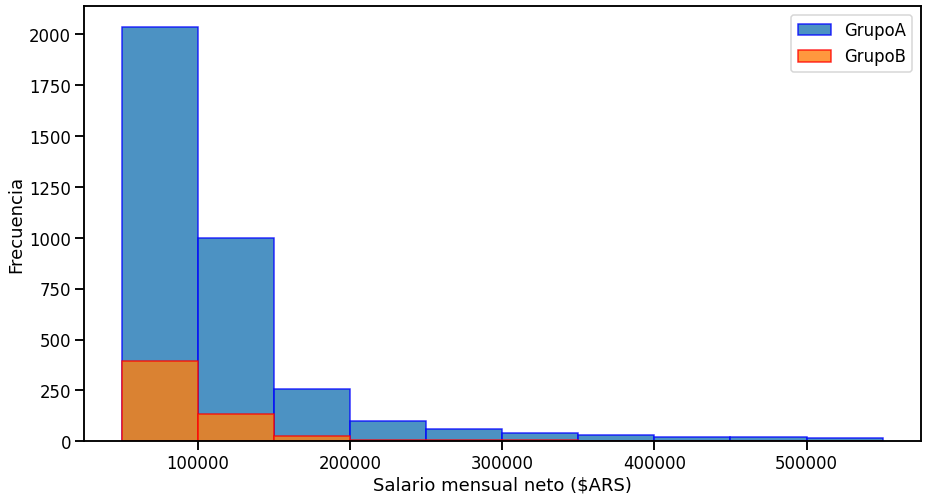

In [166]:
#Obtenemos histogramas de ambas muestras
list_bins = [50000*value for value in range(1, 12)]

plt.figure(figsize=(15,8))
plt.hist(groupA, label='GrupoA', alpha=0.8, edgecolor='blue', bins=list_bins) 
plt.hist(groupB, label='GrupoB', alpha=0.8, edgecolor='red', bins=list_bins)
plt.xlabel("Salario mensual neto ($ARS)")
plt.ylabel("Frecuencia")
plt.legend();

In [167]:
#Cálculo del tamaño de cada muestra
nA = len(groupA.index)
nB = len(groupB.index)
print("Tamaño de la muestra nA:", nA)
print("Tamaño de la muestra nB:", nB)

# Cálculo de estadístico de resta de medias muestrales
resta_mean= groupA.mean() - groupB.mean()
print("Estadístico de resta de medias muestrales:",resta_mean)

Tamaño de la muestra nA: 3582
Tamaño de la muestra nB: 577
Estadístico de resta de medias muestrales: 16610.260353965103


In [168]:
#Cálculo de varianzas
SA2 = groupA.var()
SB2 = groupB.var()
print("Varianza del groupA:", SA2)
print("Varianza del groupB:", SB2)

Varianza del groupA: 4798989758.708446
Varianza del groupB: 2097862912.8130527


In [169]:
def process_df(df):
  df = df.copy()
  df["masculino"] = df.apply(lambda x: 1 if str(x["profile_gender"]).upper() == "HOMBRE" else 0, axis=1)
  return df

df_process = process_df(df_new)
df_process["masculino"].value_counts()

1    3621
0     585
Name: masculino, dtype: int64

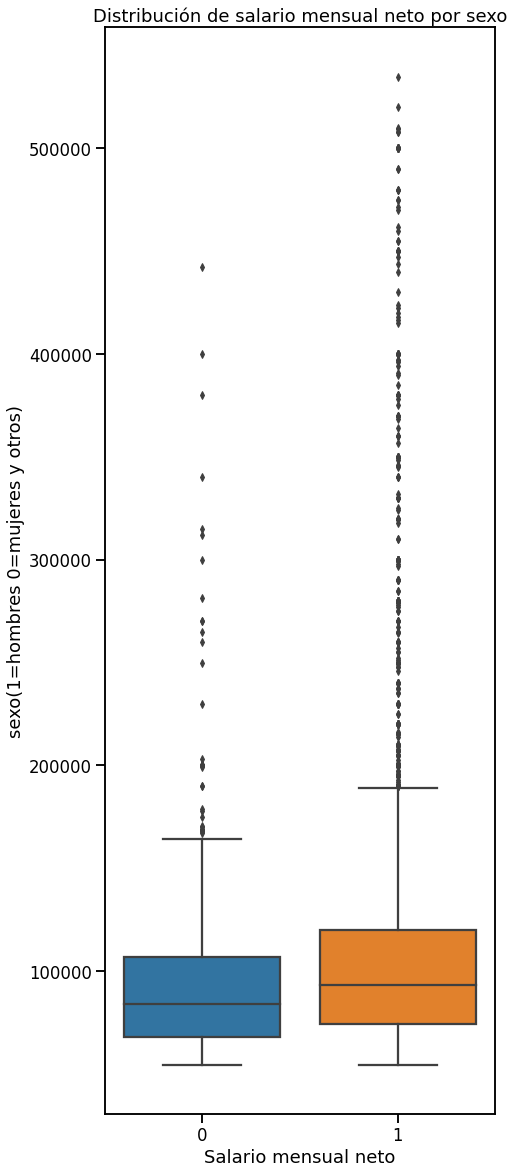

In [170]:
# Gráfico boxplot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 20))
sns.boxplot(
    x       = "masculino",
    y       = "salary_monthly_NETO",
    data    = df_process,
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de salario mensual neto por sexo')
ax.set_xlabel('Salario mensual neto')
ax.set_ylabel('sexo(1=hombres 0=mujeres y otros)');

En el gráfico precedente se presentan las dos distribuciones del Salario mensual neto para "Hombres" y, "Mujeres y Otros". Podemos observar que la amplitud de la caja para el género masculino es ligeramente mayor y la de los bigotes es bastante mayor, pudiendo sugerir que la varianza de la distribución para el género masculino es mayor que la correspondiente a los otros géneros, por lo que no podremos asumir la igualdad de varianzas.


Comparamos analíticamente varianzas para decidir qué utilizaremos como función pivote y función distribución de probabilidad. Para ello hacemos uso de tres test: Levene, Bartlett y test de Fligner-Killeen.

In [171]:
# Levene test
levene_test = stats.levene(groupA, groupB, center='median')
print(levene_test)
print("    ")

# Bartlett test
bartlett_test = stats.bartlett(groupA, groupB)
print(bartlett_test)
print("    ")

# Fligner-Killeen test
fligner_test = stats.fligner(groupA, groupB, center='median')
print(fligner_test)
print("  ")

LeveneResult(statistic=19.60562617218214, pvalue=9.763276955017239e-06)
    
BartlettResult(statistic=139.00579427264412, pvalue=4.391662009929093e-32)
    
FlignerResult(statistic=26.029588715484287, pvalue=3.362247030409009e-07)
  


El análisis anterior muestra que p_valor < $\alpha \Longrightarrow$ las varianzas son distintas. Dado que no se cumple la homocedasticidad utilizamos Test de Welch Two Sample t-test.

In [172]:
#Cáculo de los grados de libertad correspondientes al Test de Welch 
gl =  (((SA2)/nA  + (SB2)/nB)**2) / (((SA2/nA)**2 /(nA-1)) + ((SB2/nB)**2 /(nB-1)))
print("Grados de libertad:", gl)

Grados de libertad: 1055.6528187315407


In [173]:
#Cálculo de t utilizando función T- Student, considerando grados de libertad gl y percentil 1-alpha/2
alpha = 0.05
t_0975 = scipy.stats.t.ppf(q=0.975, df =gl)
print("t_0975:", t_0975)

t_0975: 1.962213727242077


In [174]:
#Cálculo de Límites inferior y superior del intervalo de confianza para la resta de medias
l_inf = resta_mean - t_0975*((SA2/nA) + (SB2/nB))**0.5
l_sup = resta_mean + t_0975*((SA2/nA) + (SB2/nB))**0.5

print("Límite inferior del intervalo de confianza para la comparación de medias muestrales:", l_inf)
print("  ")
print("Límite superior del intervalo de confianza para la comparación de medias muestrales:", l_sup)
l_inf, l_sup

Límite inferior del intervalo de confianza para la comparación de medias muestrales: 12233.35255025847
  
Límite superior del intervalo de confianza para la comparación de medias muestrales: 20987.168157671735


(12233.35255025847, 20987.168157671735)

Conclusión: encontramos que la diferencia de medias de salario entre los grupos Hombre versus Otros géneros, resultó ser de 16610,3 $\$$ARS según la estimación puntual del estadístico. Para el cálculo del intervalo de confianza con un nivel del 95%, obtuvimos un límite inferior de 12233,35 $\$$ARS y un límite máximo de 20987,17 $\$$ARS. Es posible afirmar que el grupo "Hombres" percibe un salario neto mayor que las mujeres entre 12233,35 $\$$ARS y 20987,17 $\$$ARS.

El intervalo de confianza se relaciona con la hipótesis nula ($H_0$). Si el intervalo que hemos obtenido contiene al valor de $H_0$ entonces podemos aceptar dicha hipótesis.

## Ejercicio 2: Test de hipótesis

Las pruebas o test de hipótesis son reglas de decisión basadas en los resultados de la muestra para aceptar o rechazar una conjetura o supuesto, sobre alguna característica de la población, llamado Hipótesis Nula ($H_0$).
La negación o complemento de la hipótesis nula se denomina hipótesis alternativa $H_1$ y expresa la conclusión de la inferencia en el caso de rechazo.



**Conjetura**: La distribución de los salarios es distinta entre los grupos A y B.

Para decidir si la conjetura es afirmativa o negativa realizaremos los siguientes pasos:

1)Planteo de las hipótesis

$H_0:\mu_A=\mu_B \ \ \ \ \   \ \ vs \ \  \  \  \ \ \ H_1:\mu_A>\mu_B$

2)Se fija el nivel de significancia del test ($\alpha$) en 0,05

3) Se determina el estadístico de prueba (pivote) y distribución de probabilidad (Distribución t de Student con gl grados de libertad):

 $t=\frac{\bar{x_A}-\bar{x_B}}{\sqrt{\frac{S_A ^2}{n_A} + \frac{S_B^2}{n_B}}}$    ~ $t_{gl}$

4)Decidir en base a la evidencia de la muestra si rechazar o no la hipótesis nula. Para decidir si rechazar o no la hipótesis nula se calcula el p-valor y se lo contrasta con el nivel de significancia preestablecido. Si el resultado es mayor a 0,05; concluiremos que no existe evidencia suficiente para rechazar la hipótesis nula. Si el valor es menor a 0,05; concluiremos que xiste evidencia suficiente para rechazar la hipótesis nula.



In [175]:
#Cálculo del estadístico de prueba t 
t = resta_mean / (((SA2/nA) + (SB2/nB))**0.5)
print("Estadístico de prueba t:", t)


Estadístico de prueba t: 7.446554129381828


In [176]:
#Cálculo del p-valor
p_valor = scipy.stats.t.sf(abs(t), df=gl)
print("p_valor", p_valor)

p_valor 9.931081161872911e-14


Dado que p_valor < $\alpha \Longrightarrow$  se **rechaza** la hipótesis nula



Conclusión: el resultado del test de hipótesis permite afirmar que la distribución de salarios entre los grupos es distinta.

### [Opcional] 2.3 Potencia del test

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

NOTA: este análisis debería hacerse ANTES de recolectar los datos.

In [177]:
#Cálculos de tamaños de muestra
effect_size = (groupA.mean() - groupB.mean()) / groupB.std()
# nobs1=None  - What we want to know
alpha = 0.05
ratio = len(groupB) / len(groupA)
list_power = [0.8, 0.9 , 0.95]

print("Los tamaños de muestras para potencias de 0.8, 0.9, y 0.95 son, respectivamente:")
for power in list_power:
  print(str(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio)))

Los tamaños de muestras para potencias de 0.8, 0.9, y 0.95 son, respectivamente:
431.8342882485798
577.5411514587745
713.8617293052606



Conclusión: dados los resultados de los test de potencias podemos afirmar que nuestra muestra era lo suficientemente grande para detectar las diferencias con respecto a los salarios mensuales netos.

Podemos decir que el poder estadístico de un test es la probabilidad de que la prueba encuentre una diferencia estadísticamente significativa entre el salario mensual neto que reciben los "Hombres" y "Mujeres y Otros". Nuestra muestra es lo suficientemente representativa de la tendencia general en al menos un 90%.

## Ejercicio 3: Comunicación y visualización

**Consigna:** Seleccionen un resultado que les parezca relevante a partir de alguno de los ejercicios del entregable. Diseñe e implemente una comunicación en base a este mensaje, en un archivo PDF.

Elija las palabras y visualización más adecuada para que la comunicación sea entendible, efectiva y se dapte a UNA de las siguientes situaciones:

1. Una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro.
No más de 1 página A4 (o dos si los gráficos son muy grandes).
  1. Ejemplo: Alguna de las secciones [Los ecosistemas de emprendimiento de América Latina y el Caribe frente al COVID-19: Impactos, necesidades y recomendaciones](https://publications.iadb.org/es/los-ecosistemas-de-emprendimiento-de-america-latina-y-el-caribe-frente-al-covid-19-impactos-necesidades-y-recomendaciones), por ejemplo la sección *2.2. Reacciones de los emprendedores*.
  2. Ejemplo: Alguna de las secciones de [The state of gender pay gap in 2021](https://www.payscale.com/data/gender-pay-gap?tk=carousel-ps-rc-job)
  3. Puntos clave: 
    1. Simpleza de los gráficos.
    2. Comunicación en lenguaje simple a personas que no son necesariamente expertos de dominio.
    2. Selección de UNA oración sobre la que se hace énfasis.
    3. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

2. Una publicación científica o reporte técnico interno. No más de una página A4:
  2. Ejemplo: La sección de resultados de [IZA DP No. 12914: The Impact of a Minimum Wage Change on the Distribution of Wages and Household Income](https://www.iza.org/publications/dp/12914/the-impact-of-a-minimum-wage-change-on-the-distribution-of-wages-and-household-income).
  2. Ejemplo: Alguna de las secciones de [Temporary reduction in daily global CO2 emissions during the COVID-19 forced confinement](https://www.nature.com/articles/s41558-020-0797-x)
  3. Puntos clave:
    3. Nivel de detalle técnico requerido. Es necesario justificar la validez del análisis.
    4. La idea presentada puede ser más compleja. Pueden asumir que la audiencia tiene conocimiento técnico y va a analizar las visualizaciones en detalle. 
    5. Pueden presentar más en detalle las limitaciones del análisis (significancia estadística, etc.)
    2. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

3. Un tweet (o post de LinkedIn) para la cuenta de su empresa consultora que hace análisis de datos. El objetivo es promocionar un análisis de datos abiertos que van a incluir en su portfolio:
  1. Ejemplo: [Comparación vacunas covid](https://twitter.com/infobeautiful/status/1381577746527236098?s=20)
  2. Ejemplo: [Tweet del BID](https://twitter.com/el_BID/status/1388508583944507396?s=20). Lo valioso de este tweet es que usaron un único número para transmitir un mensaje. Puede ser algo así, o con un gráfico muy simple.
  3. Ejemplo: [Cambio climático](https://twitter.com/UNFCCC/status/1387732156190011394?s=20) Es un muy buen ejemplo, excepto que el gráfico no se lee nada y hay que entrar a la publicación original.
  3. Ejemplo: [¿Cuánto están los programadores en las empresas?](https://www.linkedin.com/posts/denis-rothman-0b034043_tech-career-work-activity-6793861923269054464-gS6y) (No verificamos la veracidad o seriedad de la fuente).
  4. Puntos clave:
    1. Su audiencia no va a mirar la visualización por más de unos segundos, y no tiene conocimiento técnico.
  3. Tienen que incluir además una *breve* descripción de cómo obtuvieron los datos que están presentando, que no entraría en el tweet.
